In [1]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))
library(GSA)
library(forcats)
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS', 'Raw')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(label) {
    
    read_tsv(paste0('../results/single_cell/', label, '_prediction.tsv'), col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
        ungroup %>%
        mutate(label = paste(tools::toTitleCase(label), 'et al.'))

}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ readr   1.1.1
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ ggplot2 3.1.0     ✔ stringr 1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ purrr::flatten()    masks jsonlite::flatten()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::select()     masks AnnotationDbi::select()
✖ purrr::simplify()   masks clusterProfiler::simplify()
✖ dplyr::slice()      masks I

# Benchmark

In [2]:
sc <- bind_rows(summarize_benchmark('haber'), summarize_benchmark('habib'), summarize_benchmark('villani'))

raw <- filter(sc, model == 'Raw')
sc <- filter(sc, model != 'Raw')

We analyzed the following datasets:

- [Haber et al.](https://portals.broadinstitute.org/single_cell/study/small-intestinal-epithelium): 15,972 genes x 7,216 cells
- [Habib et al.](https://portals.broadinstitute.org/single_cell/study/-single-nucleus-rna-seq-of-cell-diversity-in-the-adult-mouse-hippocampus-snuc-seq): 25,393 genes x 13,302 cells
- [Villani et al.](https://portals.broadinstitute.org/single_cell/study/atlas-of-human-blood-dendritic-cells-and-monocytes): 23,395 genes x 1,140 cells

They were imputed with MAGIC, then followed a feature selection step + kNN classifier.

Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

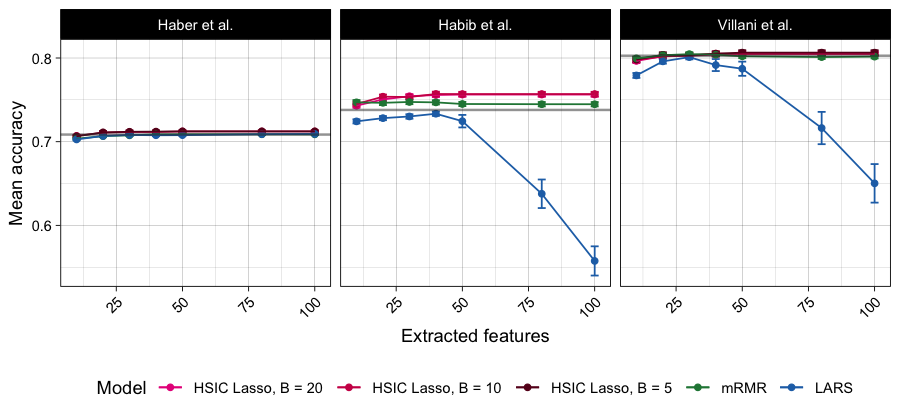

In [3]:
options(repr.plot.width=7.5, repr.plot.height=3.5)

ggplot(sc, aes(x = selected, y = accuracy, color = model)) +
    geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
    geom_point() +
    geom_line() +
    geom_hline(data = raw, aes(yintercept = accuracy), size = 0.7, 
               colour = 'gray20', alpha = 0.5) + 
    theme_linedraw() +
    theme(legend.position = 'bottom',
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
    scale_color_manual(values = palette) +
    facet_grid(. ~ label)

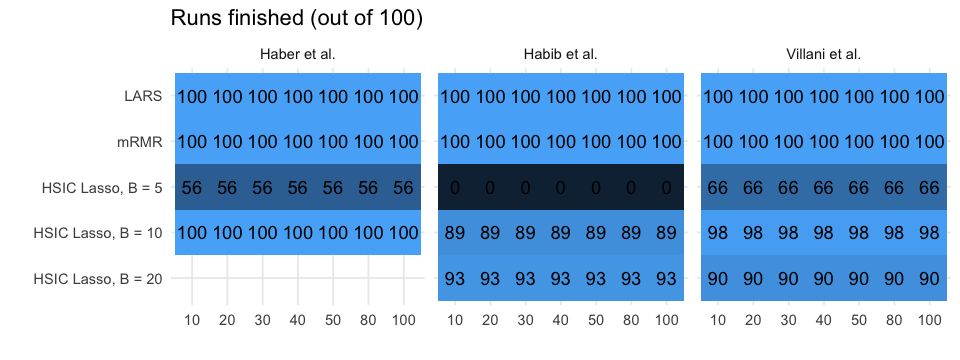

In [4]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(sc, aes(x = model, y = factor(selected), fill = ended, label = ended)) +
    geom_tile() +
    geom_text() +
    theme_minimal() +
    theme(legend.position = 'none') +
    labs(x = '', y = '', title = 'Runs finished (out of 100)') +
    coord_flip() +
    facet_grid(. ~ label)

# Analysis of the datasets

In [5]:
pathways_mouse <- suppressPackageStartupMessages(
    read.gmt(gmtfile = "../data/Mus_musculus_GSEA_GO_sets_bp_symbols_highquality_April_2015.gmt")) %>%
    mutate(gene = tools::toTitleCase(tolower(gene)))
pathways_human <- read.gmt(gmtfile = "../data/c2.cp.v6.2.symbols.gmt")

read_predictions <- function(label) {
    
    x <- bind_rows(read_tsv(paste0('../results/single_cell/', label, '_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'HSIC Lasso, B = 20'),
          read_tsv(paste0('../results/single_cell/', label, '_lars_C=50.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'LARS'),
          read_tsv(paste0('../results/single_cell/', label, '_mrmr_C=50.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'mRMR'))
    
    # number of features selected
    print(table(x$Method))

    # number of features selected by more than one method
    x %>%
        group_by(Gene) %>%
        summarize(n = as.character(n())) %>%
        filter(n > 1) %>%
        print
    
    return(x)
    
}

plot_pathways <- function(genes, pathways) {
    
    rank <- inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        group_by(ont) %>%
        summarize(n = length(unique(Method)))

    inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        inner_join(rank, by = "ont") %>%
        arrange(-n) %>%
        group_by(Gene, Method) %>%
        summarize(ont = head(ont, 1)) %>%
        group_by(ont) %>%
        filter(length(unique(Method)) >= 2) %>%
        ungroup %>%
        mutate(ont = gsub('\\([0-9]\\)', '', ont),
               ont = gsub('REACTOME_', '', ont),
               ont = gsub('KEGG_', '', ont),
               ont = gsub('PID_', '', ont),
               ont = tools::toTitleCase(ont),
               ont = gsub('_', ' ', ont)) %>%
        ggplot(aes(fct_infreq(ont), fill = Method)) +
            geom_bar() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position = 'bottom') +
            labs(x = '', y = 'Count') +
            coord_flip() +
            scale_fill_manual(values = palette)
    
}

We run our three approaches on the different datasets to analyze the retrieved biomarkers.

## Haber *et al.*: mouse intestine

In [6]:
haber <- read_predictions('haber')


HSIC Lasso, B = 20               LARS               mRMR 
                50                 34                 50 
# A tibble: 1 x 2
  Gene  n    
  <chr> <chr>
1 Krt18 2    


Only one gene is selected by more than one method.

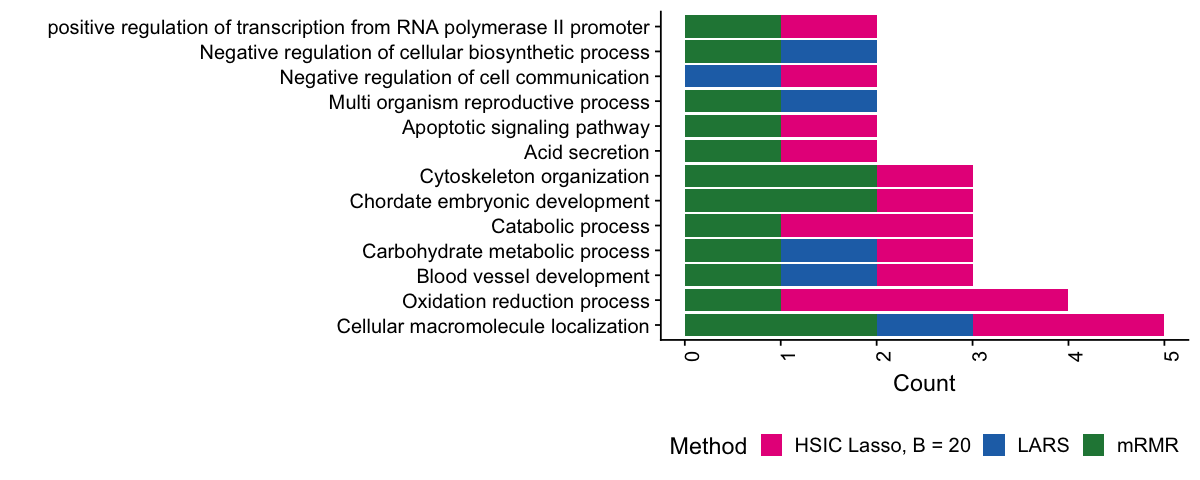

In [7]:
rank <- inner_join(haber, pathways_mouse, by = c('Gene' = 'gene')) %>%
    group_by(ont) %>%
    summarize(n = length(unique(Method)))

options(repr.plot.width=10, repr.plot.height=4)
plot_pathways(haber, pathways_mouse)

We associate one GO Term (Biological process) to each gene, and see if different methods are selecting related genes. We find 13 biological functions that are selected by different methods.

## Habib *et al.*: mouse hipocampus

In [8]:
habib <- read_predictions('habib')


HSIC Lasso, B = 20               LARS               mRMR 
                50                 35                 50 
# A tibble: 1 x 2
  Gene   n    
  <chr>  <chr>
1 Elavl2 2    


Again, only one gene is selected by more than one method.

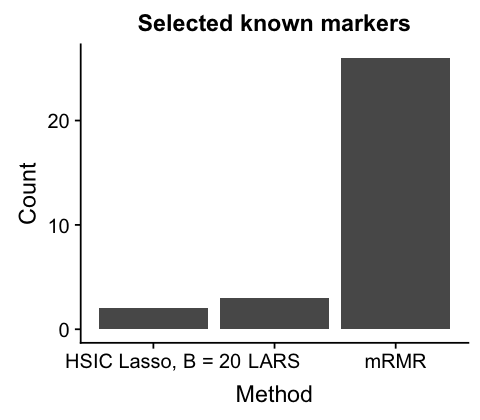

In [9]:
markers <- c(read_tsv('~/data/single_cell/habib/Major_cell_types_marker_genes.txt',
                      col_types = 'cddddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/Glia_subcluster_marker_genes.txt',
                         col_types = 'cdddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/GABAergic_edit_subcluster_marker_gene.txt',
                         col_types = 'cdddddddd') %>% .$`GENE NAMES`)

options(repr.plot.width=4, repr.plot.height=3.5)
habib %>% filter(Gene %in% markers) %>%
    ggplot(aes(x = Method)) +
        geom_bar() +
        labs(y = 'Count', title = 'Selected known markers')

For this dataset, the authors provided a list of 1,669 genes that are known to be different among the cell subpopulations. We checked which method was selecting more of them. Interestingly, almost half of mRMR selected features intersects with this list.

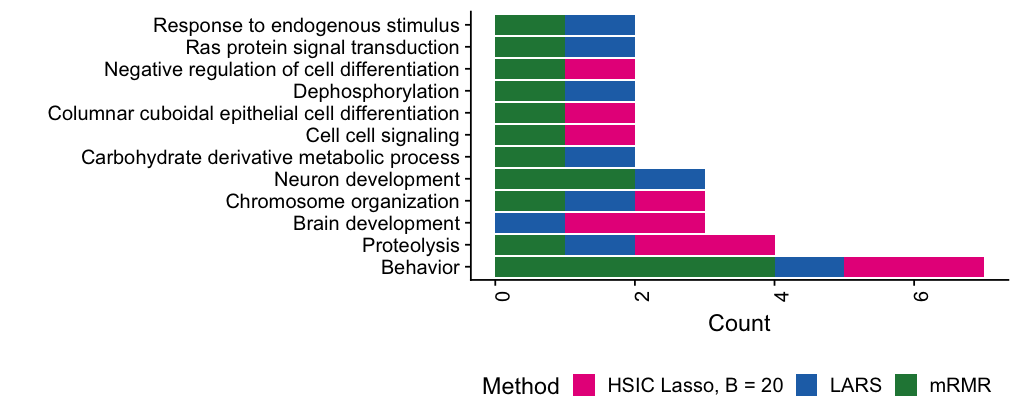

In [10]:
options(repr.plot.width=8.5, repr.plot.height=3.5)
plot_pathways(habib, pathways_mouse)

As before, we aggregated genes into pathways, finding 12 biological processes affected by several genes. In this case, the GO terms are easily interpretable, as many of them are related to brain development and signalling. It is remarkable that despite HSIC Lasso retrieved only one of the known markers, it retrieved some others that are involved in known brain functions, opening the doors to the discovery of new biomarkers.

## Villani *et al.*: human blood

In [11]:
villani <- bind_rows(read_tsv(paste0('../results/single_cell/villani_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
                   mutate(Method = 'HSIC Lasso, B = 20'),
                   read_tsv('../results/single_cell/villani_lars_C=50.txt', 
                            col_names = 'Gene', col_types = 'c') %>%
                   mutate(Method = 'LARS'))

table(villani$Method)


HSIC Lasso, B = 20               LARS 
                50                 39 

In the Villani dataset we couldn't apply mRMR as it crashes. There are no genes shared by different techniques.

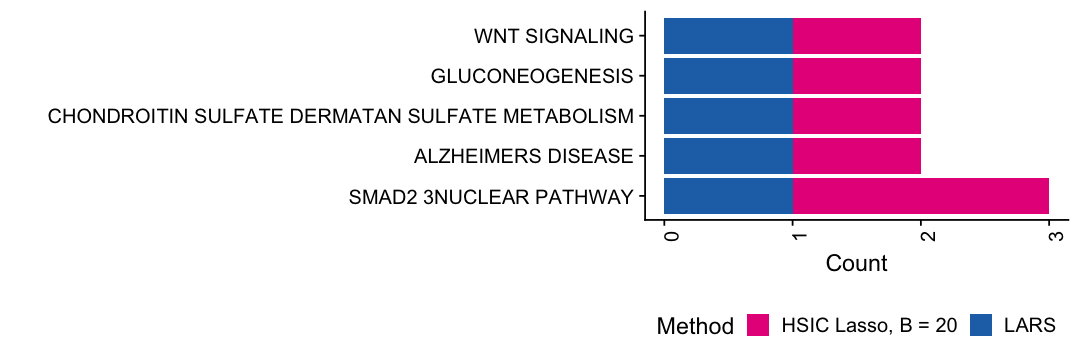

In [12]:
options(repr.plot.width=9, repr.plot.height=3)
plot_pathways(villani, pathways_human)